# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/transformer_vae'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define Transformer based auto-encoder

- Split 64 * 64 image into 8 * 8 patches (total 8 * 8 = 64 blocks)
- Every block have input length of 8 * 8 * 3 = 192 dimension
- Project the patch into 256 dimension embedding
- Add Positional Encoding to it
- Go through 4 layer of 8 heads transformers with 512 MLP dimension

And the decoder works reversely.

In [2]:
import math

# Define the positional encoding
class PositionalEncoding2D(nn.Module):
    def __init__(self, dim, image_size, patch_size):
        super(PositionalEncoding2D, self).__init__()
        self.encoding = nn.Parameter(self.create_positional_encoding(dim, image_size, patch_size), requires_grad=False)

    def create_positional_encoding(self, dim, image_size, patch_size):
        num_patches = (image_size // patch_size) ** 2
        encoding = torch.zeros(num_patches, dim)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        
        # Calculate row and column positions
        row_pos = position // (image_size // patch_size)
        col_pos = position % (image_size // patch_size)
        
        div_term = torch.exp(torch.arange(0, dim, 4).float() * (-math.log(10000.0) / dim))
        
        encoding[:, 0::4] = torch.sin(row_pos * div_term)
        encoding[:, 1::4] = torch.cos(row_pos * div_term)
        encoding[:, 2::4] = torch.sin(col_pos * div_term)
        encoding[:, 3::4] = torch.cos(col_pos * div_term)
        
        return encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding

# Define the Vision Transformer autoencoder model
class TransformerAutoencoder(nn.Module):
    def __init__(self, image_size=64, patch_size=8, dim=128, depth=4, heads=8, mlp_dim=1024, bottleneck_dim=32, dropout_rate=0.1):
        super(TransformerAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.dim = dim
        self.bottleneck_dim = bottleneck_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.flatten_dim = patch_size * patch_size * 3

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.patch_embedding = nn.Linear(self.flatten_dim, dim)
        self.positional_encoding = PositionalEncoding2D(dim, image_size, patch_size)
        self.mean_bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        self.logvar_bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        
        #self.bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        self.decoder_input = nn.Linear(bottleneck_dim, dim * self.num_patches)

        # Define the decoder as a transformer encoder
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=depth)

        self.output_layer = nn.Linear(dim, self.flatten_dim)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        # Divide the image into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim)

        # Embed patches and add positional encoding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)

        # Transformer encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mean = self.mean_bottleneck(x)
        logvar = self.logvar_bottleneck(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std

    def decode(self, x):
        # Transformer decoding
        x = self.decoder_input(x)
        x = x.view(x.size(0), -1, self.dim)
        x = self.decoder(x)

        # Reshape back to image
        # Output layer to reshape back to image
        x = self.output_layer(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x = self.decode(z)
        return x, mean, logvar
    
class TransformerAutoencoderWrapper(nn.Module):
    def __init__(self, model):
        super(TransformerAutoencoderWrapper, self).__init__()
        self.model = model 
    
    def forward(self, x):
        x, mean, logvar = self.model(x)
        return x, mean

In [3]:
from util import calc_and_plot_metrics, fit_nearest_neighbor, train_vae_model_steps, plot_model, count_parameters, save_to_file, load_from_file

def train_model(patch_size=8, dim=128, depth=4, heads=8, mlp_dim=256, embedding_size=32, dropout_rate=0.1, learning_rate=1e-4, weight_decay=1e-5, num_epochs=50):
    # Initialize the model
    model = TransformerAutoencoder(
        patch_size=patch_size,
        dim=dim,
        depth=depth, 
        heads=heads,
        mlp_dim=mlp_dim,
        bottleneck_dim=embedding_size, 
        dropout_rate=dropout_rate
    )
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_vae_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    model = TransformerAutoencoderWrapper(model)
    fit_nearest_neighbor(model)
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from dim = 512)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 1215816


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.299
Shape Accuracy: 0.696
Combined Accuracy: 0.227


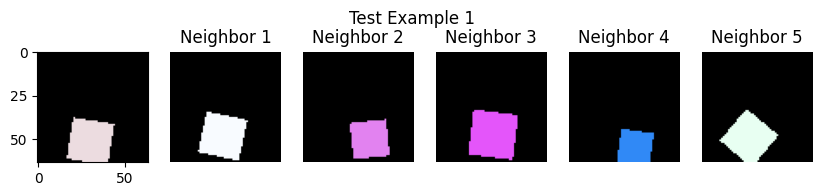

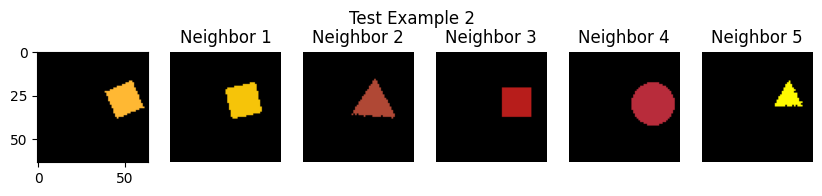

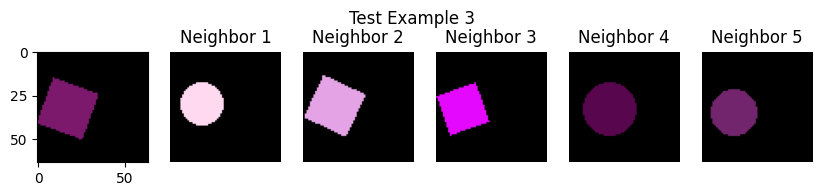

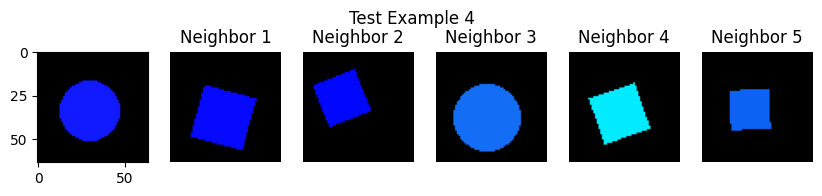

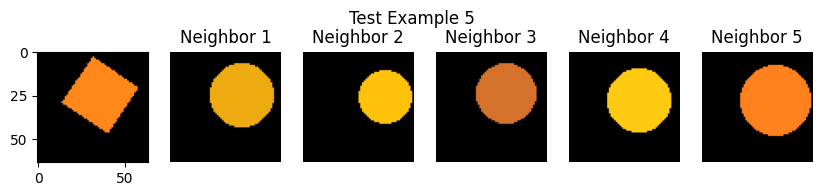

Silhouette Score: -0.12844473123550415
Cluster Purity: 0.212
Normalized Mutual Information (NMI): 0.2874520798121663


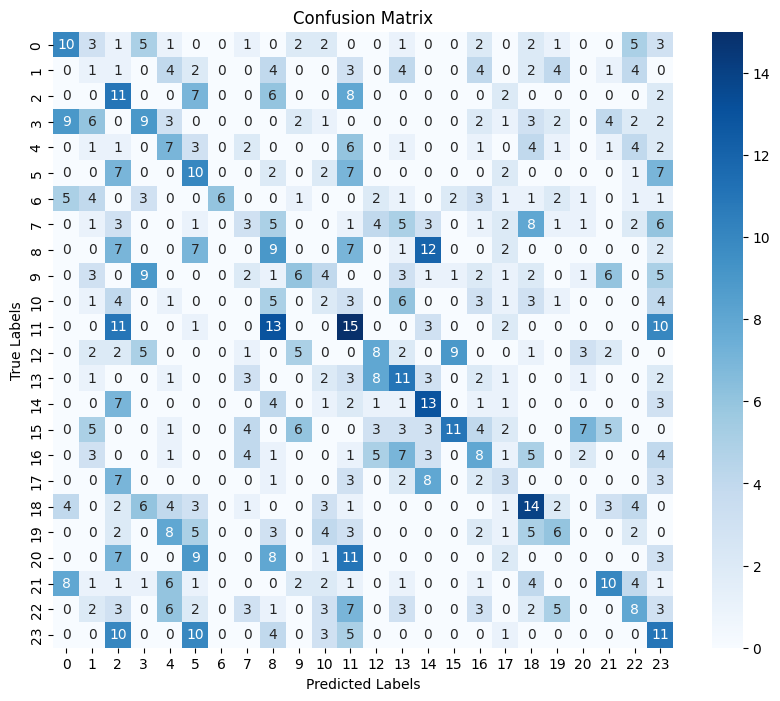

Silhouette Score: -0.051816534250974655
Cluster Purity: 0.23
Normalized Mutual Information (NMI): 0.08426112509232464


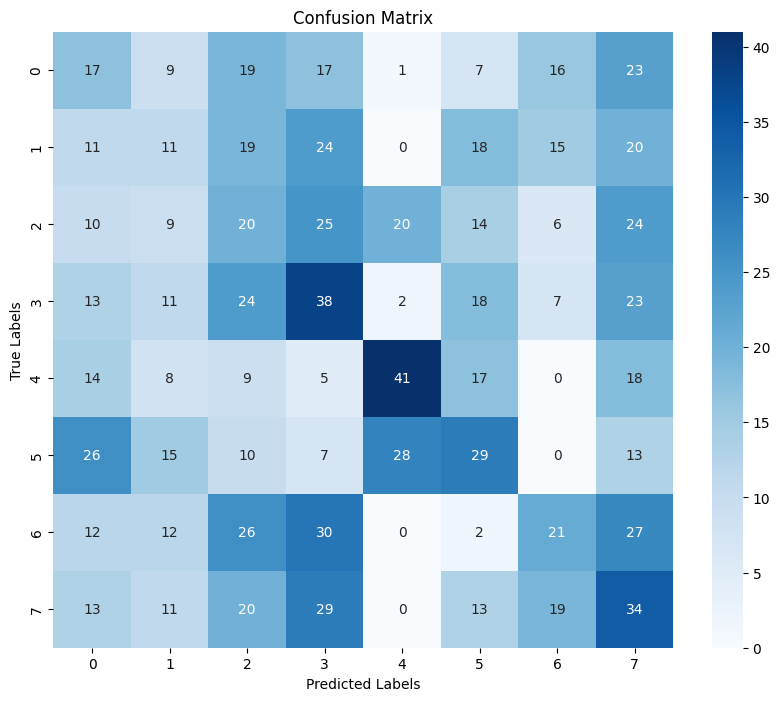

Silhouette Score: 0.060344401746988297
Cluster Purity: 0.562
Normalized Mutual Information (NMI): 0.22167091984560136


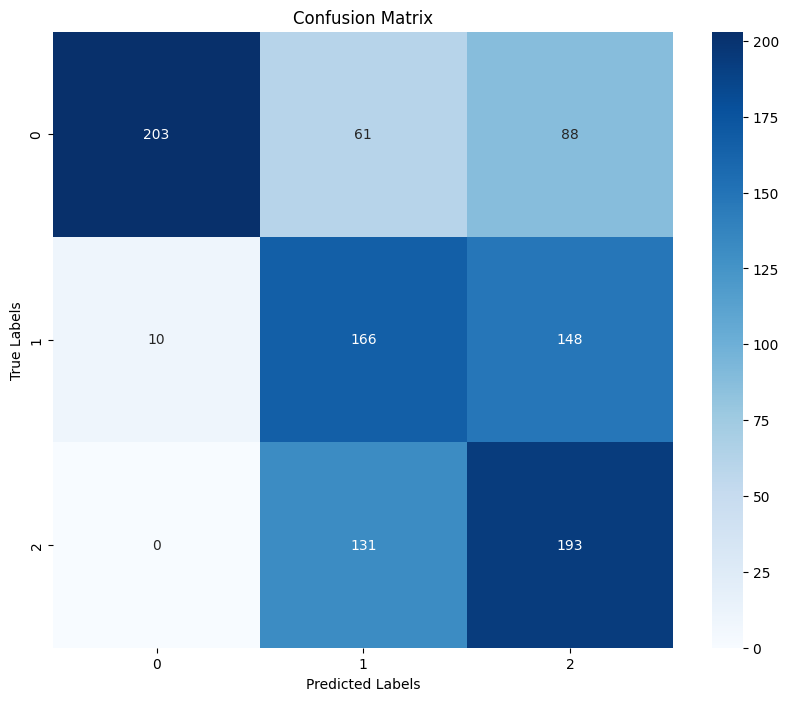

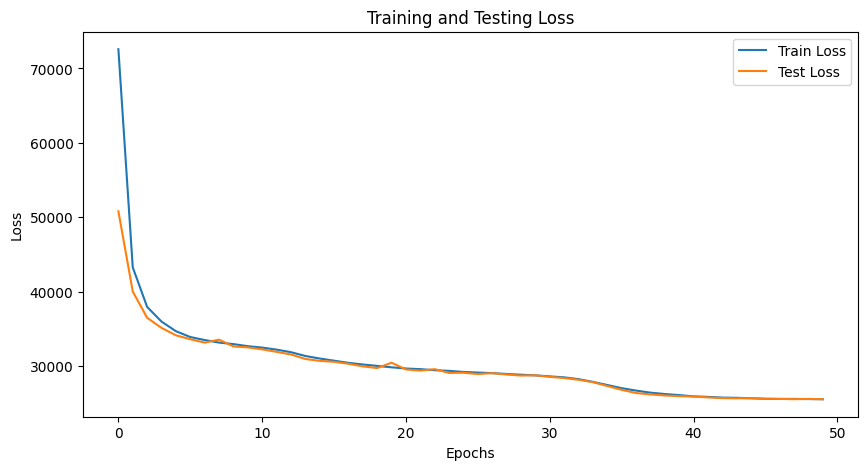

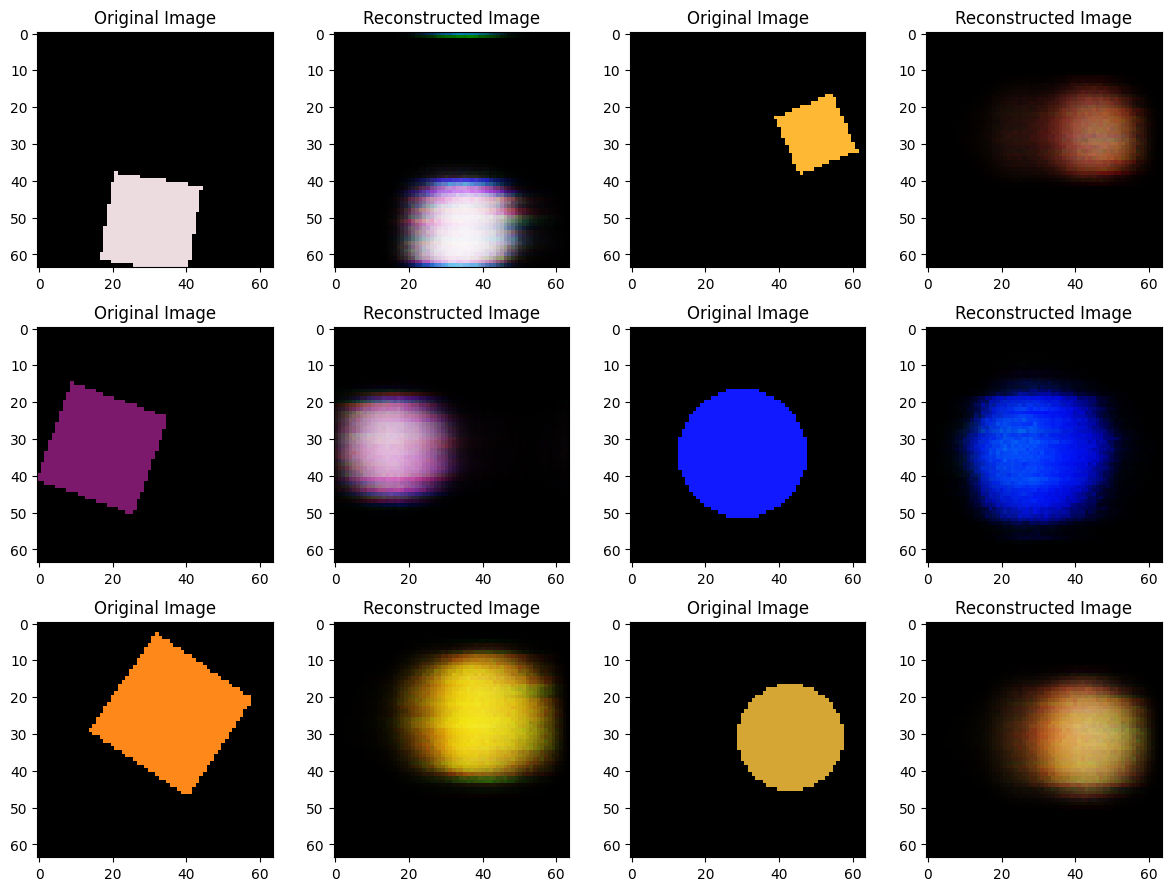

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 1314128


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.408
Shape Accuracy: 0.722
Combined Accuracy: 0.292


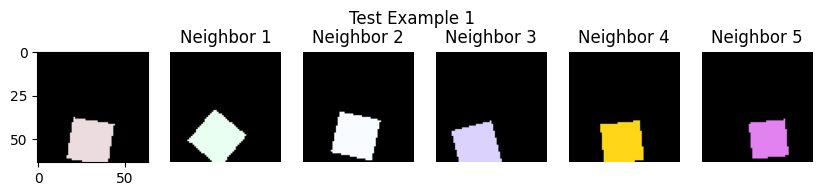

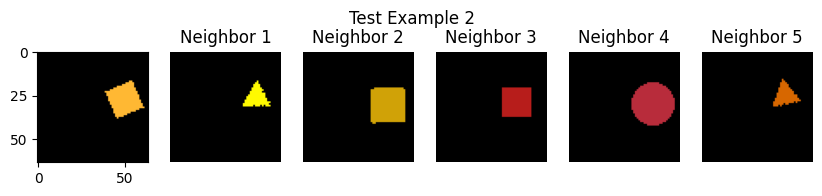

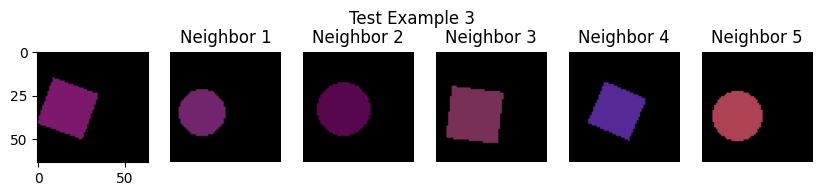

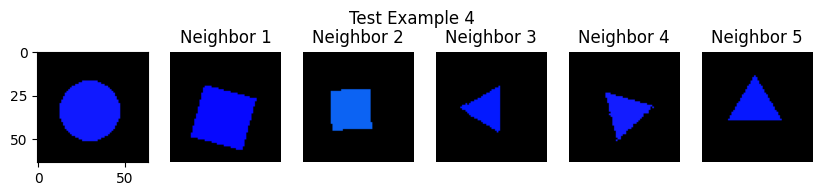

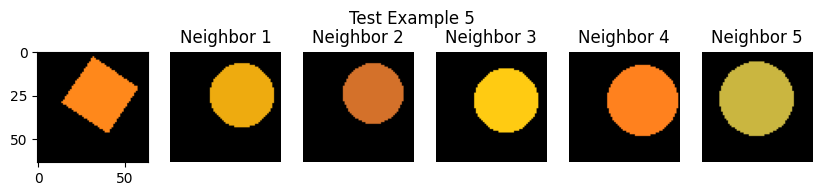

Silhouette Score: -0.11436709761619568
Cluster Purity: 0.219
Normalized Mutual Information (NMI): 0.2765064494958748


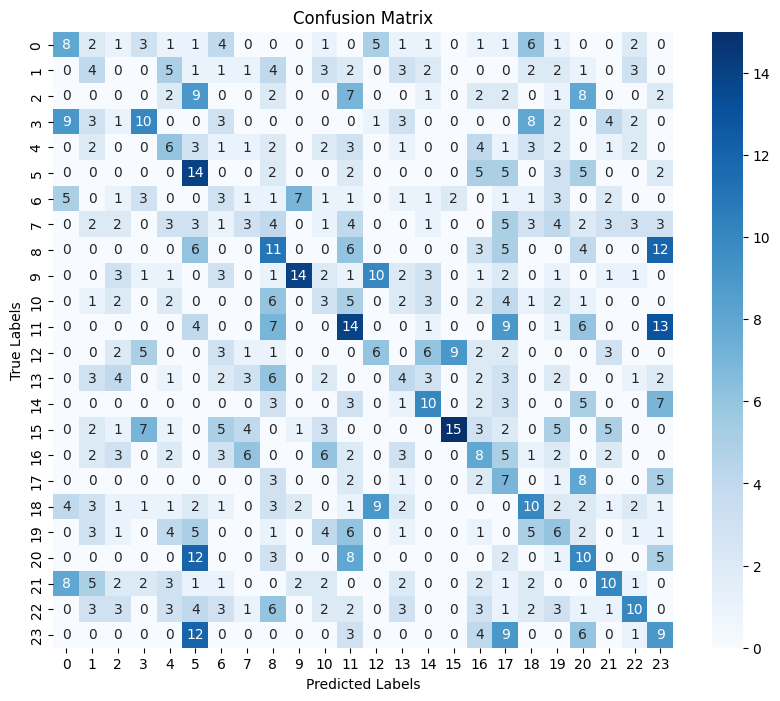

Silhouette Score: -0.06722711026668549
Cluster Purity: 0.219
Normalized Mutual Information (NMI): 0.04042711471481343


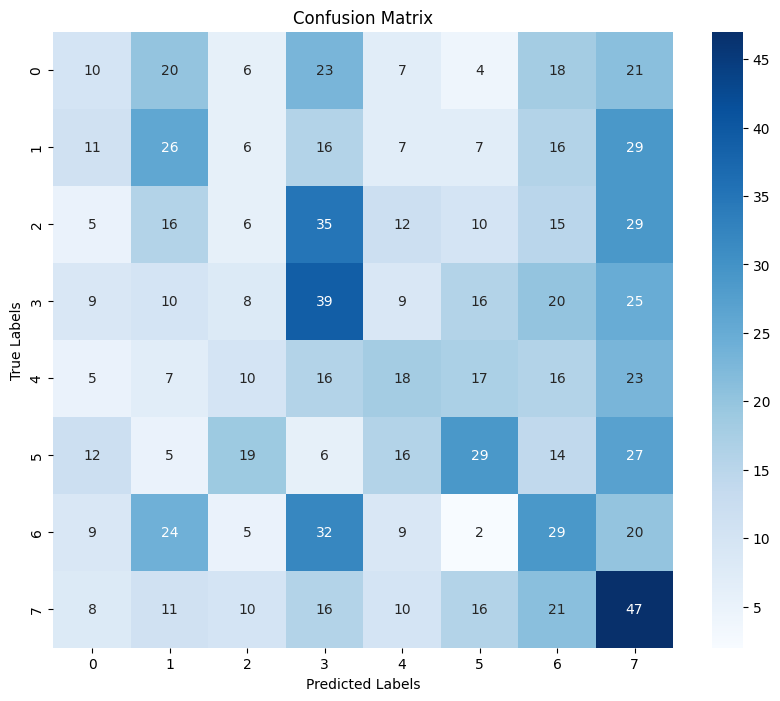

Silhouette Score: 0.051120467483997345
Cluster Purity: 0.563
Normalized Mutual Information (NMI): 0.20157073282699936


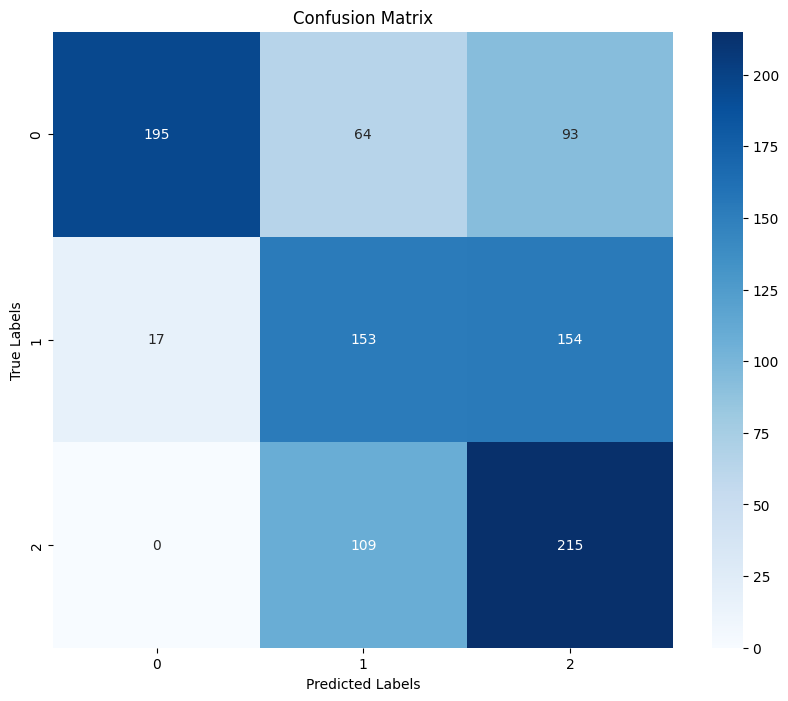

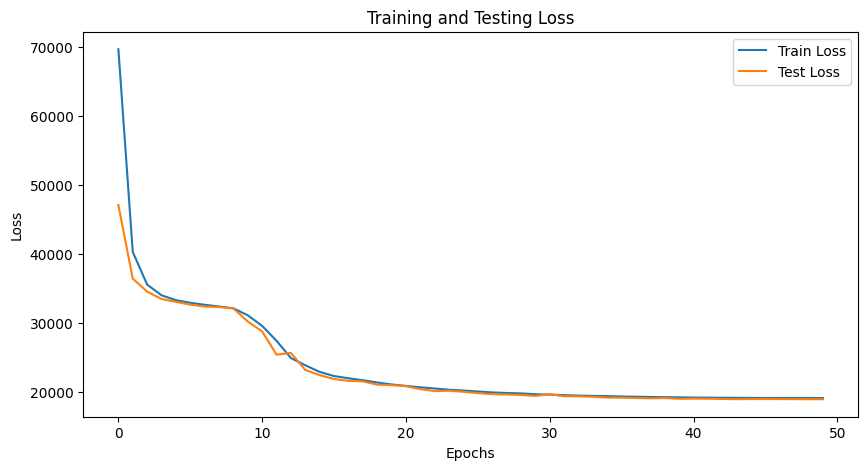

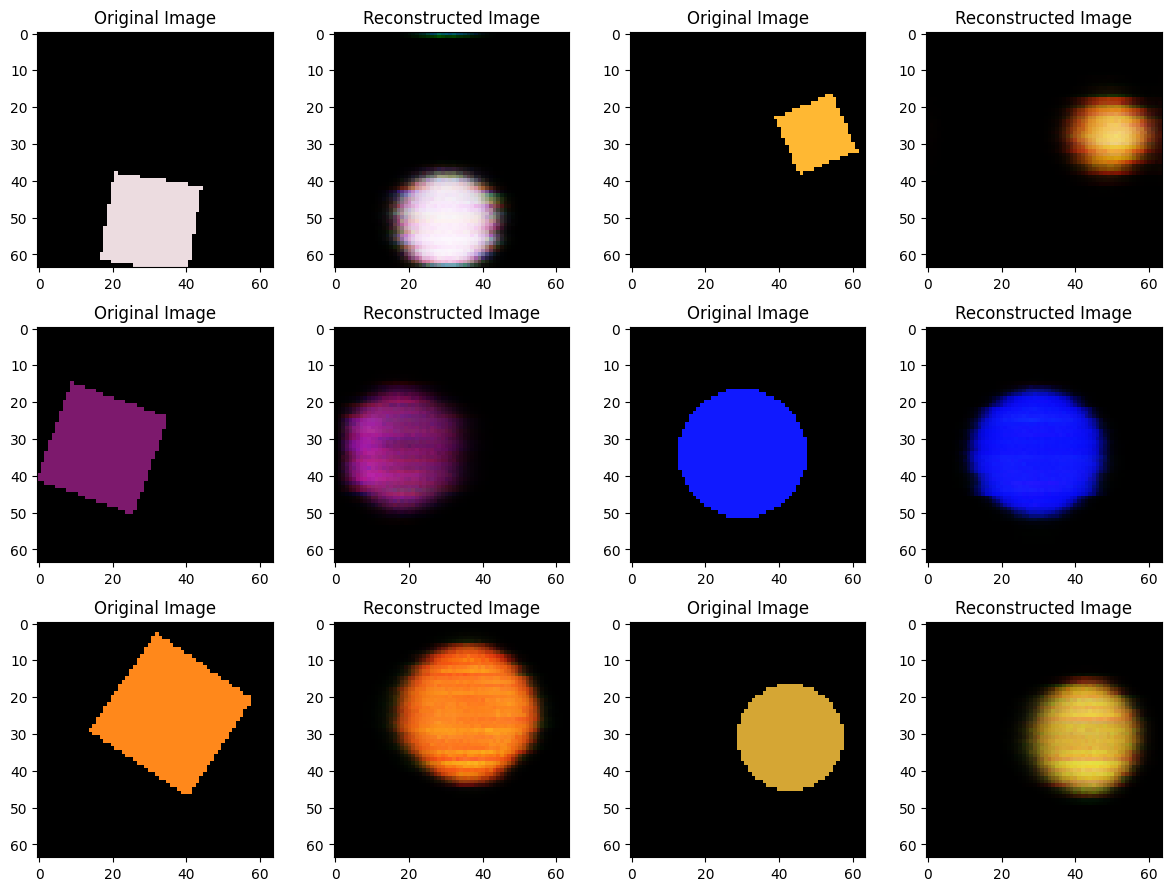

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1510752


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.416
Shape Accuracy: 0.729
Combined Accuracy: 0.296


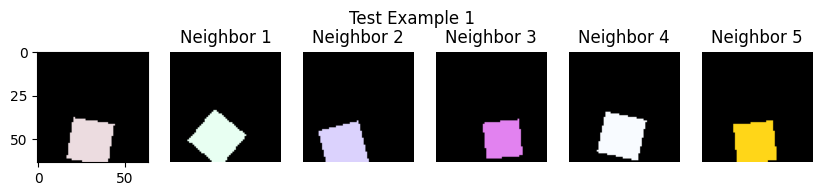

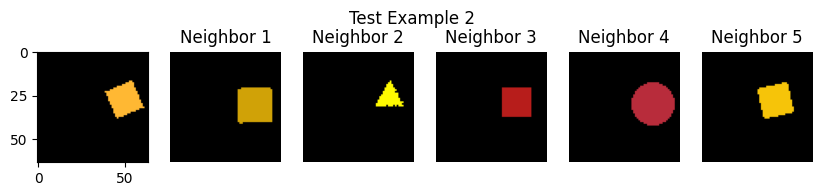

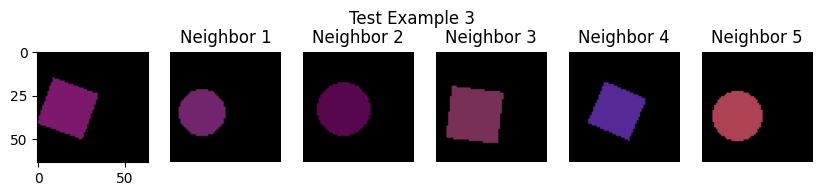

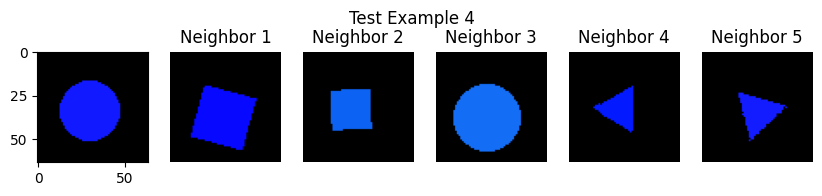

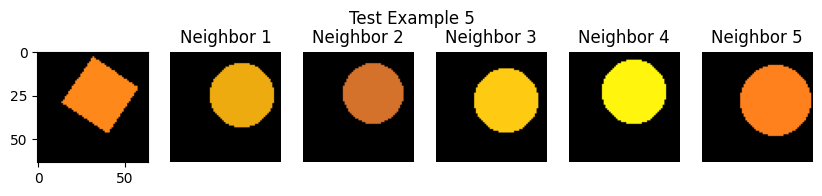

Silhouette Score: -0.10251280665397644
Cluster Purity: 0.221
Normalized Mutual Information (NMI): 0.2855149579842572


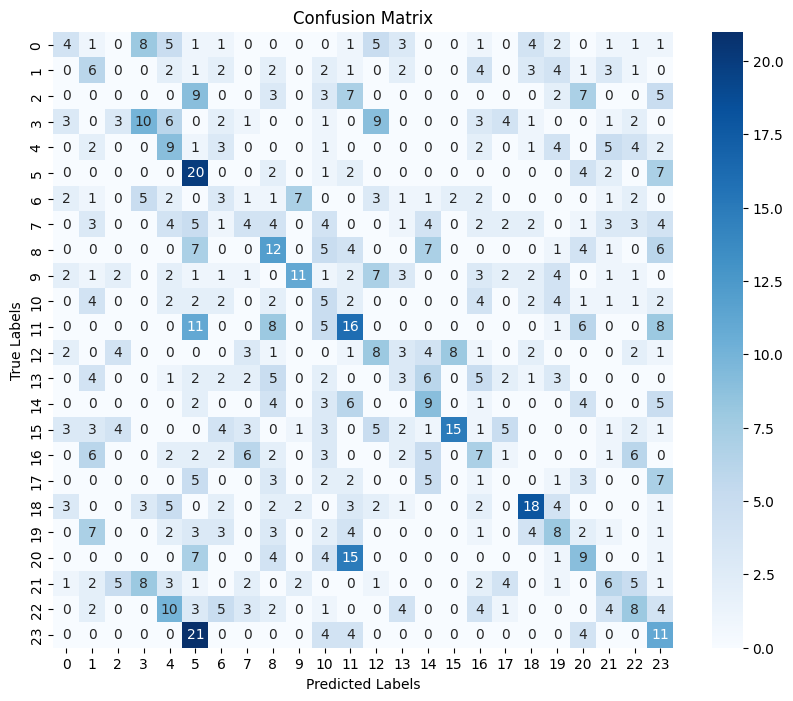

Silhouette Score: -0.07090233266353607
Cluster Purity: 0.202
Normalized Mutual Information (NMI): 0.04332879317754434


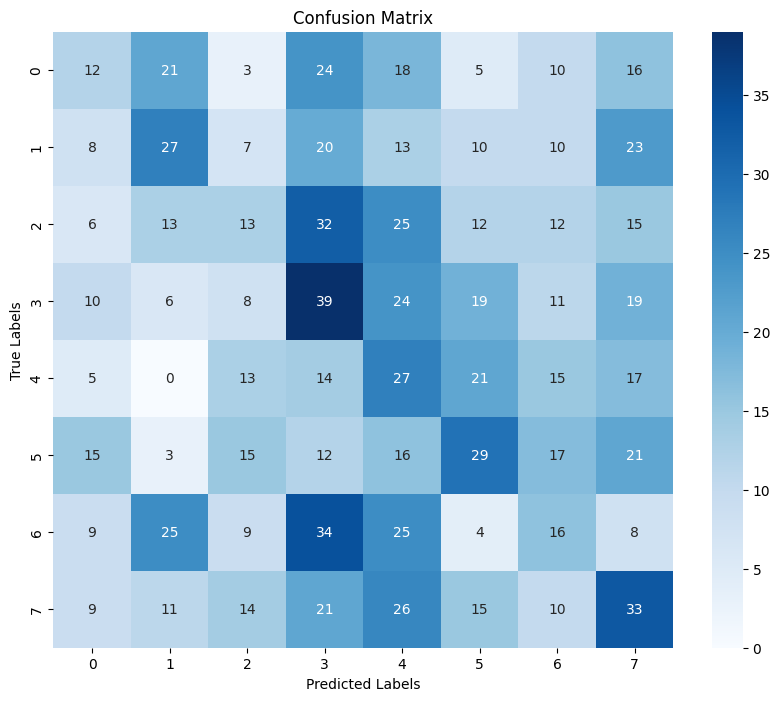

Silhouette Score: 0.039118435233831406
Cluster Purity: 0.568
Normalized Mutual Information (NMI): 0.2092340312509635


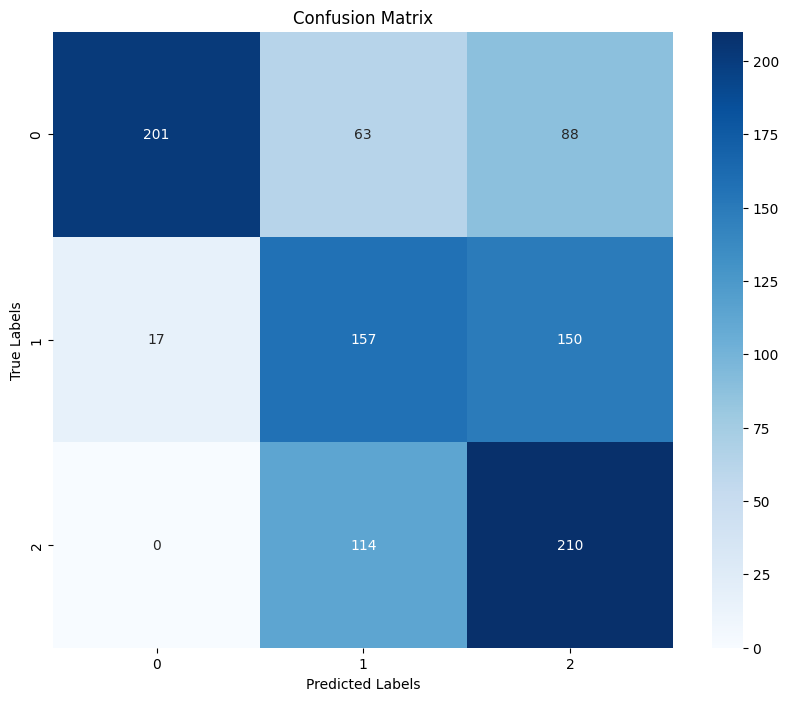

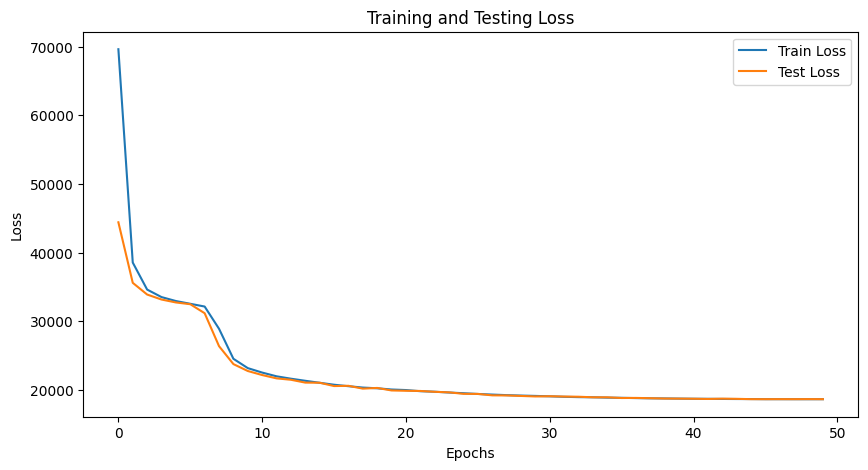

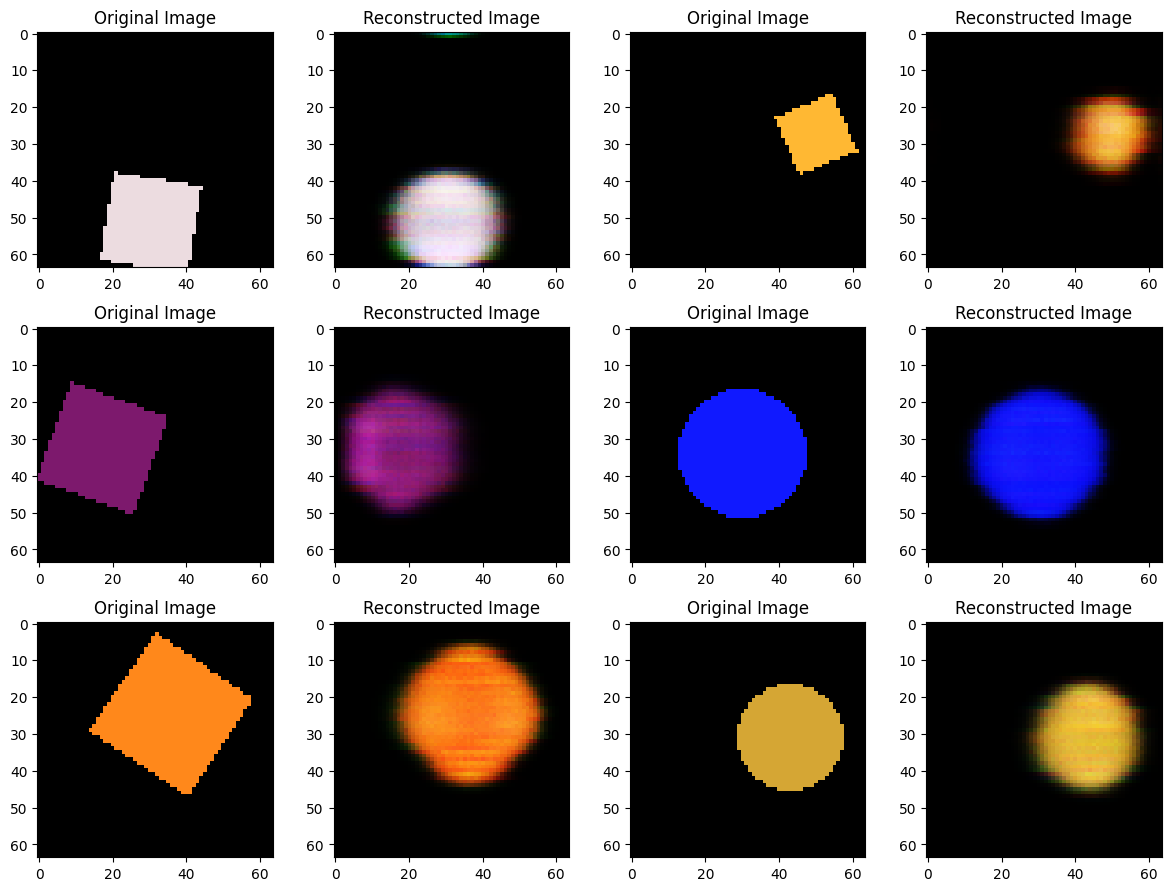

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1904000


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.379
Shape Accuracy: 0.746
Combined Accuracy: 0.268


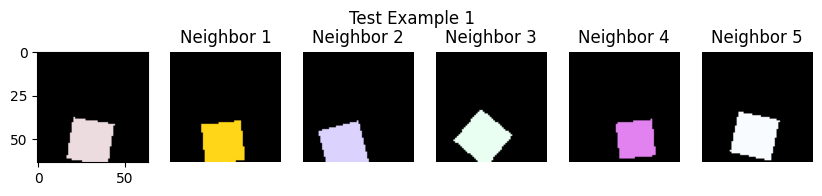

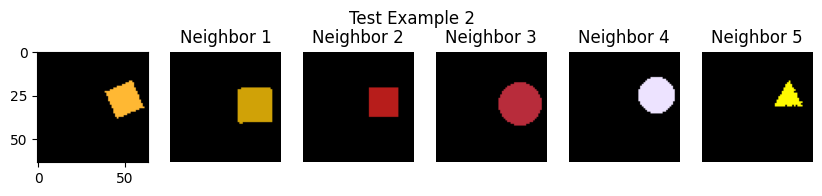

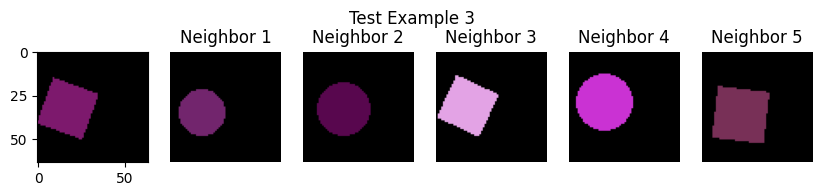

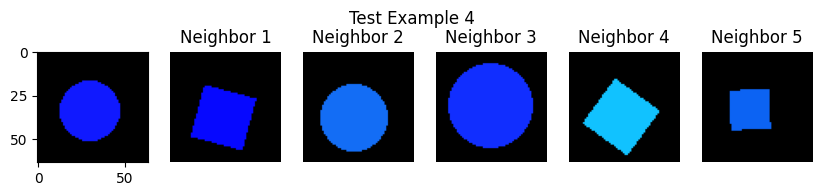

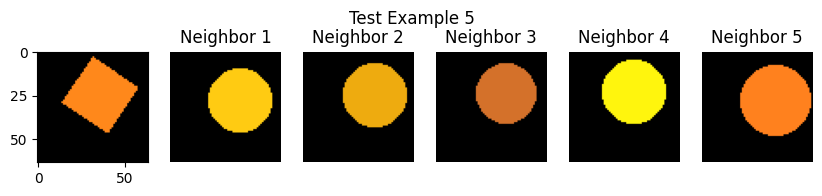

Silhouette Score: -0.0581979937851429
Cluster Purity: 0.206
Normalized Mutual Information (NMI): 0.2727278345566879


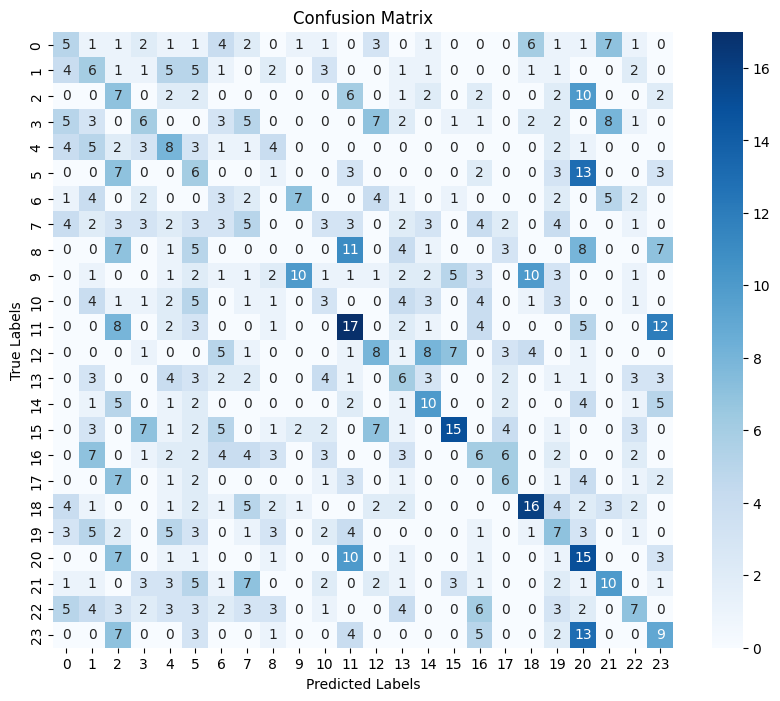

Silhouette Score: -0.023078331723809242
Cluster Purity: 0.195
Normalized Mutual Information (NMI): 0.030200452224279344


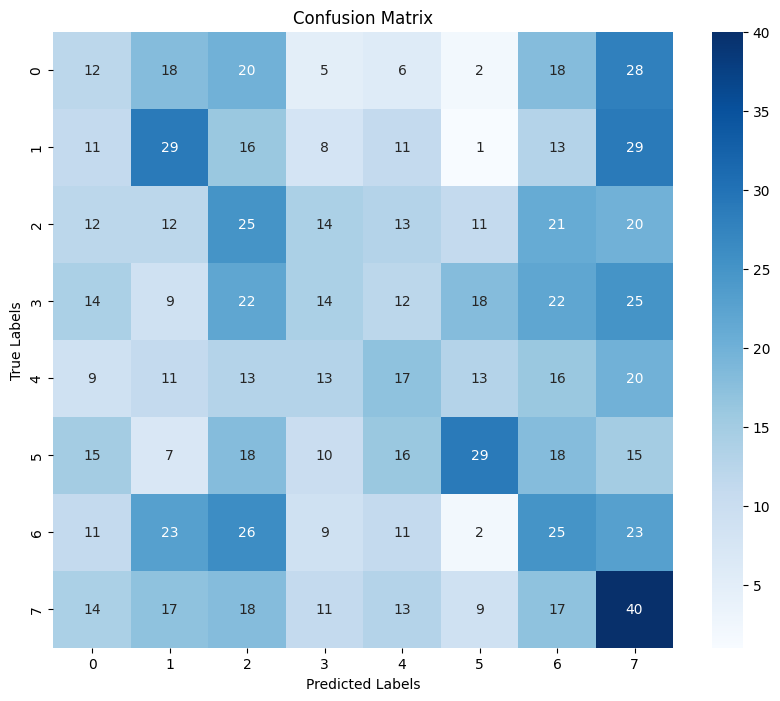

Silhouette Score: 0.03795498609542847
Cluster Purity: 0.588
Normalized Mutual Information (NMI): 0.22702400222154648


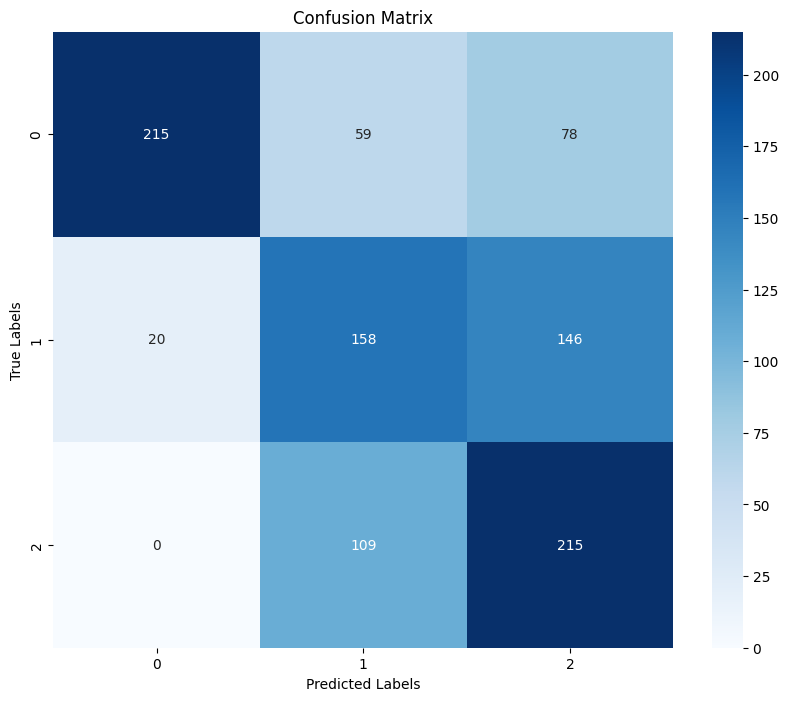

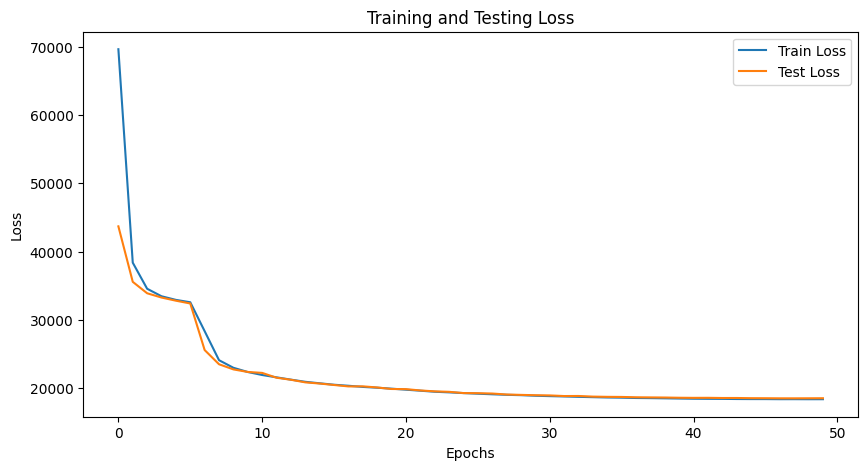

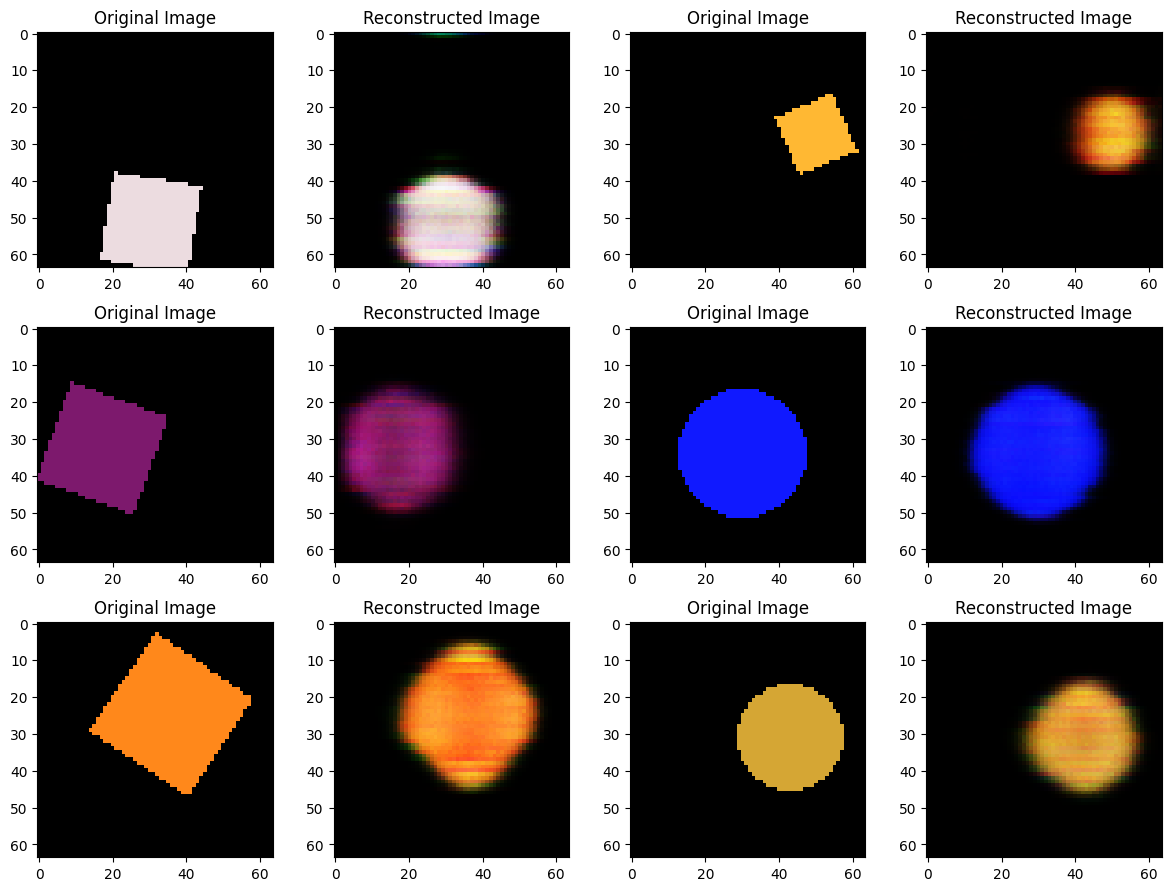

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 2690496


/Users/criyle/project/cse5524/cse5524final/util.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.34
Shape Accuracy: 0.776
Combined Accuracy: 0.249


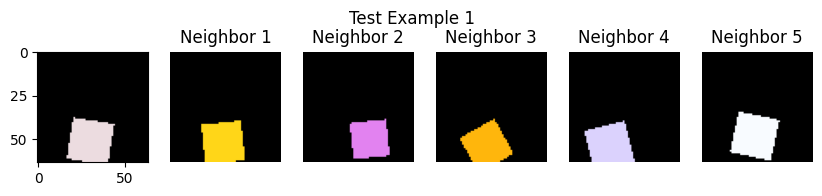

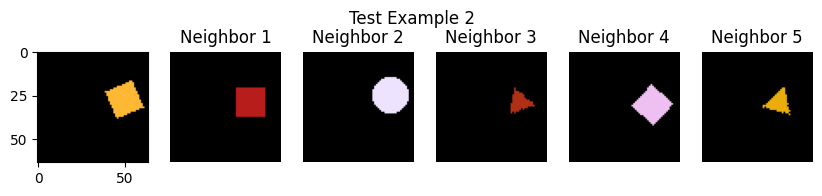

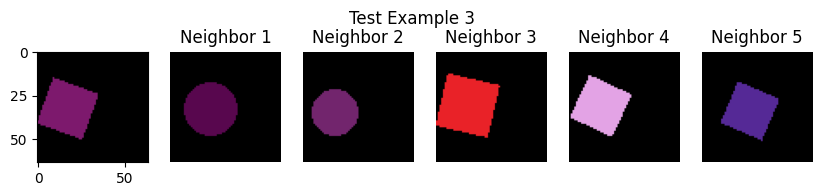

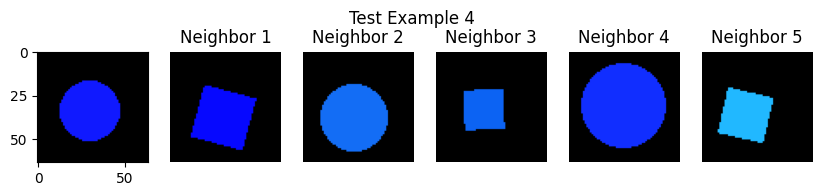

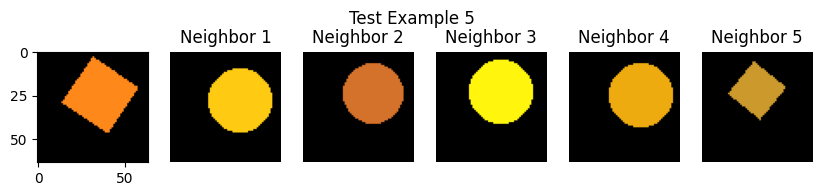

Silhouette Score: -0.0507274754345417
Cluster Purity: 0.207
Normalized Mutual Information (NMI): 0.28048719649609094


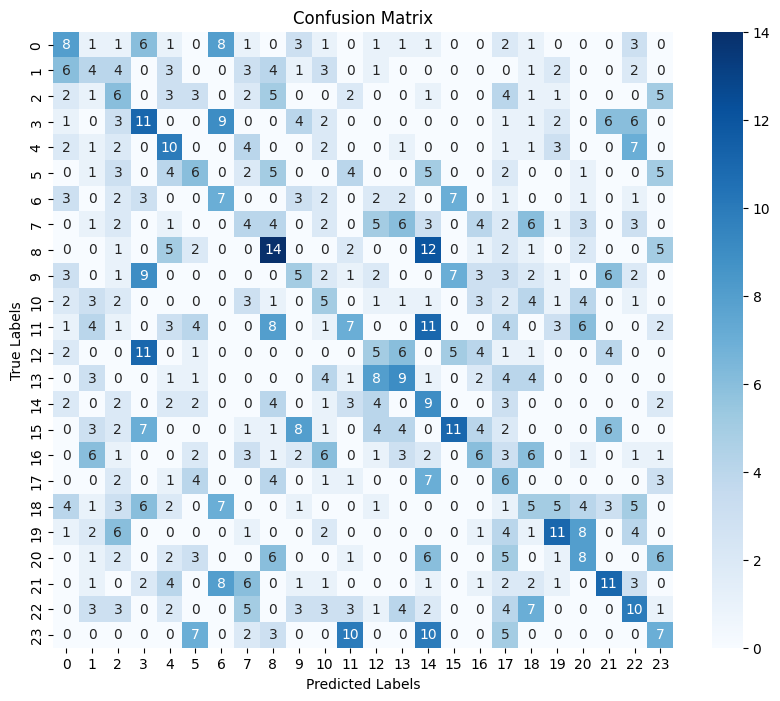

Silhouette Score: -0.01681920886039734
Cluster Purity: 0.194
Normalized Mutual Information (NMI): 0.033784023546833825


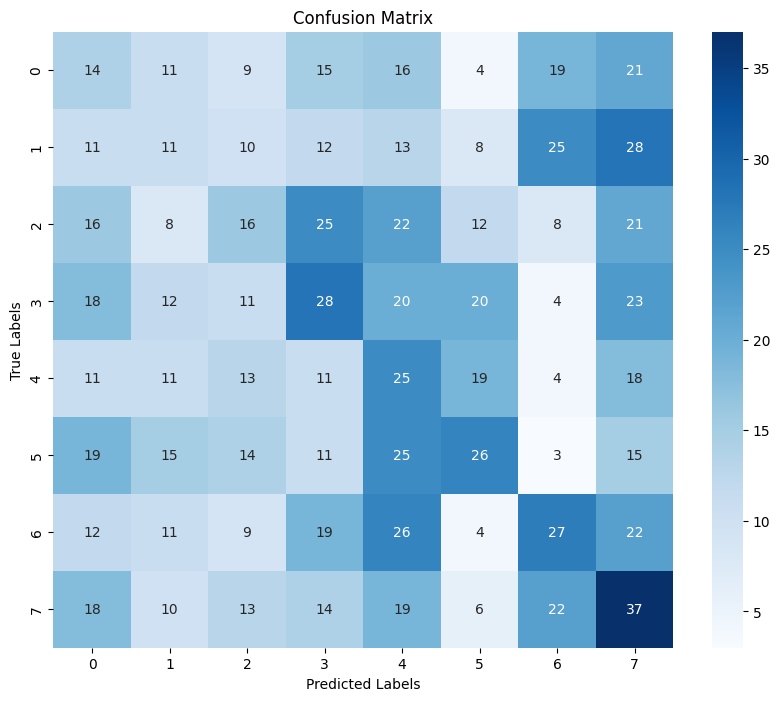

Silhouette Score: 0.02869313769042492
Cluster Purity: 0.569
Normalized Mutual Information (NMI): 0.21964596708284895


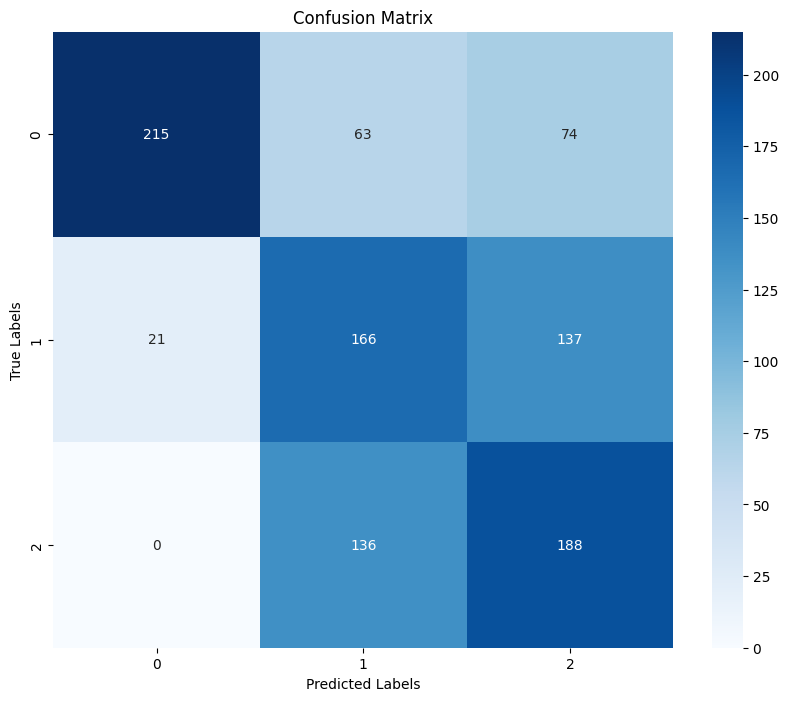

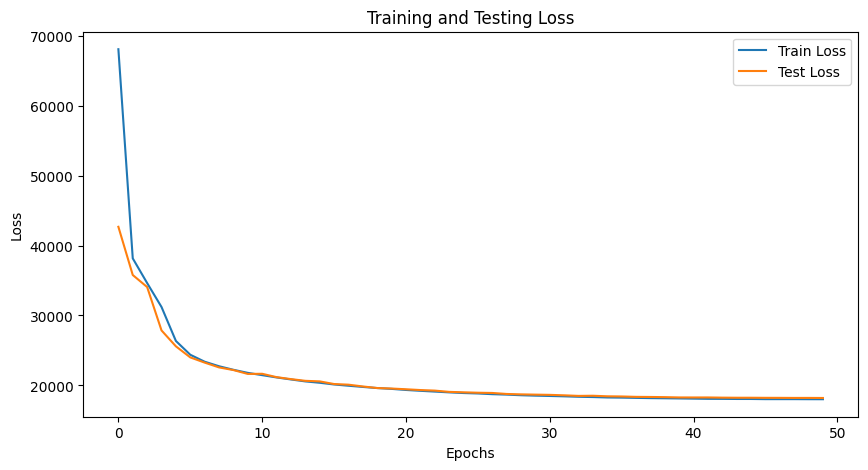

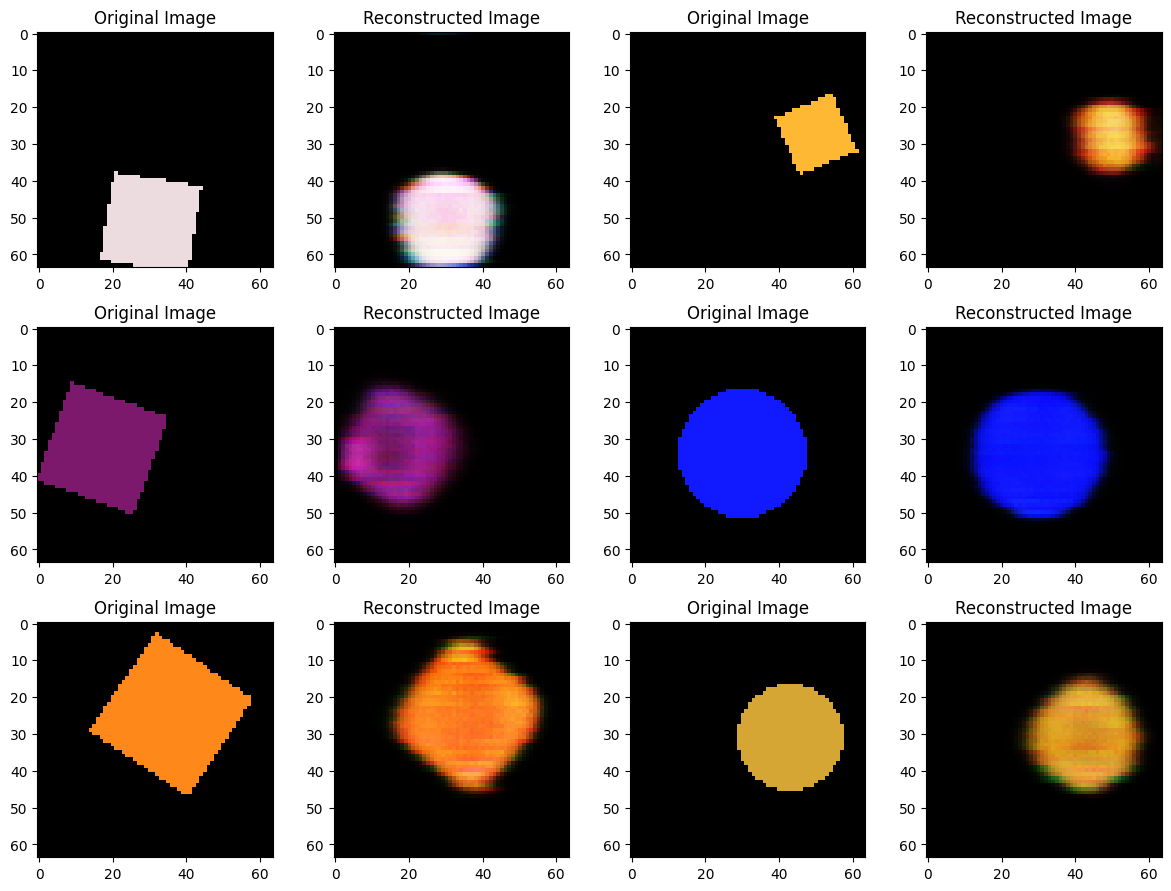

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)